In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import defaultdict, deque
import time
import os
import json
from itertools import permutations, islice, product

In [2]:
tasks = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('D', 'E')]
delays = {'A': 1, 'B': 1, 'C': 4, 'D': 1, 'E': 3}

In [3]:
class Individual:
    def __init__(self, schedule, edges, delay):
        self.schedule = schedule
        self.fitness = self.calc_fitness(edges, delay)

    #ako ne zadovoljava topsort fitness->inf inace izracunaj max(S)
    def calc_fitness(self, edges, delay):
        if not is_valid_schedule(self.schedule, edges):
            return float('-inf')
        graph, predak = inicialize_graph(edges)
        return -calculate_S(self.schedule, graph, delay, predak)[1]
        
    def __lt__(self, other):
        return self.fitness < other.fitness

In [4]:
def is_valid_schedule(schedule, edges):
    task_to_index = {task: index for index, task in enumerate(schedule)}
    for u, v in edges:
        if task_to_index[u] > task_to_index[v]:
            return False
    return True

In [5]:
def inicialize_graph(edges):
    graph = defaultdict(list)
    predak = defaultdict(list)

    for u, v in edges:
        graph[u].append(v)
        predak[v].append(u)

    return graph, predak

In [6]:
def calculate_S(permutation, graph, delay, predak):
    S = {t: 0 for t in permutation}
    for node in permutation:
        max_S = S[node]
        for prec in predak[node]:
            max_S = max(S[node], S[prec] + delay[prec] + 1)

        #ako postoji node sa istim S, uvecamo ga za 1
        while max_S in S.values():
            max_S += 1
        S[node] = max_S

    return S, max(S.values())

In [7]:
def create_initial_population(size_of_population, tasks, edges, delays):
    population = [] 
    selected_permutations = list(islice(permutations(tasks), size_of_population))
    random.shuffle(selected_permutations)
    
    for schedule in selected_permutations:
        individual = Individual(list(schedule), edges, delays)
        population.append(individual)
        
    return population

In [8]:
def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    return max(chosen)

### various crossover methods

In [9]:
def crossover(parent1, parent2):
    idx1, idx2 = sorted(random.sample(range(len(parent1.schedule)), 2))
    child = [None] * len(parent1.schedule)
    child[idx1:idx2+1] = parent1.schedule[idx1:idx2+1]
    
    current_pos = 0
    for task in parent2.schedule:
        if task not in child:
            while child[current_pos] is not None:
                current_pos += 1
            child[current_pos] = task
    return child

In [10]:
def partially_mapped_crossover(parent1, parent2):
    size = len(parent1.schedule)
    start, end = sorted(np.random.choice(size, 2, replace=False))
    
    offspring1 = [None] * size
    offspring2 = [None] * size
    
    offspring1[start:end+1] = parent1.schedule[start:end+1]
    offspring2[start:end+1] = parent2.schedule[start:end+1]
    
    mapping1 = {parent1.schedule[i]: parent2.schedule[i] for i in range(start, end+1)}
    mapping2 = {parent2.schedule[i]: parent1.schedule[i] for i in range(start, end+1)}
    
    def fill_offspring(offspring, mapping, parent):
        for i in range(size):
            if offspring[i] is None:
                gene = parent.schedule[i]
                while gene in mapping:
                    gene = mapping[gene]
                offspring[i] = gene
    
    fill_offspring(offspring1, mapping1, parent2)
    fill_offspring(offspring2, mapping2, parent1)
    
    return offspring1, offspring2

In [11]:
def cycle_crossover(parent1, parent2):
    size = len(parent1.schedule)
    offspring1 = [None] * size
    offspring2 = [None] * size
    visited = [False] * size
    
    def find_cycle(start):
        cycle = []
        while not visited[start]:
            visited[start] = True
            cycle.append(start)
            start = parent1.schedule.index(parent2.schedule[start])
        return cycle
    
    for i in range(size):
        if not visited[i]:
            cycle = find_cycle(i)
            for pos in cycle:
                offspring1[pos] = parent1.schedule[pos]
                offspring2[pos] = parent2.schedule[pos]
    
    # Fill remaining genes
    for i in range(size):
        if offspring1[i] is None:
            offspring1[i] = parent2.schedule[i]
        if offspring2[i] is None:
            offspring2[i] = parent1.schedule[i]
    
    return offspring1, offspring2

### various mutation methods

In [12]:
def mutate(individual):
    idx1, idx2 = random.sample(range(len(individual)), 2)
    individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

In [13]:
def inversion_mutation(individual):
    size = len(individual)
    idx1, idx2 = np.sort(np.random.choice(size, 2, replace=False))
    
    individual[idx1:idx2+1] = individual[idx1:idx2+1][::-1]

In [14]:
def scramble_mutation(individual):  
    size = len(individual)
    idx1, idx2 = np.sort(np.random.choice(size, 2, replace=False))
    
    subset = individual[idx1:idx2+1]
    np.random.shuffle(subset)
    individual[idx1:idx2+1] = subset

In [15]:
def mutate_number_of_times(individual):
    num_swaps=2
    for _ in range(num_swaps):
        mutate(individual)

In [16]:
def swap_and_invert_mutation(individual):
    mutate(individual)
    inversion_mutation(individual)

### Genetic Algorithm

In [38]:
def genetic_algorithm(mutation_func, crossover_func, population_size, num_generations, 
                      tournament_size, elitism_size, mutation_prob,
                      tasks, edges, delays):
    population = create_initial_population(population_size, tasks, edges, delays)
    new_population = []
    start_time = time.time()
    
    for i in range(num_generations):
        population = sorted(population, reverse=True)
        new_population[:elitism_size] = population[:elitism_size]
        for j in range(elitism_size, population_size):
            parent1 = selection(population, tournament_size)#nz dal se razlikuju
            parent2 = selection(population, tournament_size)

            child1, child2 = [], []
            if crossover_func.__name__ == 'crossover':
                child1 = crossover_func(parent1, parent2)
                child2 = crossover_func(parent1, parent2)
            else:
                child1, child2 = crossover_func(parent1, parent2)
            
            if random.random() < mutation_prob:
                mutation_func(child1)
            if random.random() < mutation_prob:
                mutation_func(child2)
                
            new_population.append(Individual(child1, edges, delays))
            new_population.append(Individual(child2, edges, delays))
            
        population = new_population.copy()
        
    end_time = time.time()
    time_taken = end_time - start_time
    best_individual = max(population)
    print(f'solution: {best_individual.schedule}, cost: {-best_individual.fitness}, time taken: {time_taken}')
    return best_individual.schedule, -best_individual.fitness, time_taken

In [97]:
def draw_graph(tasks, edges, delays, file_name, big_graphs=False, topological_order=None, save_path='graphs/'):
    G = nx.DiGraph()
    
    G.add_nodes_from(tasks)
    G.add_edges_from(edges)
    
    # Dynamic figure size based on the number of nodes
    num_nodes = len(tasks)
    if big_graphs:
        plt.figure(figsize=(12 + num_nodes * 0.2, 12 + num_nodes * 0.2))  # Adjust size dynamically
    else:
        plt.figure(figsize=(8, 8))  # Default size for small graphs
    
    if topological_order:
        # Ensure all nodes are in the topological order
        if len(topological_order) != len(tasks):
            raise ValueError("Topological order does not include all tasks.")
        
        # Use graphviz_layout for hierarchical drawing
        pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    else:
        pos = nx.spring_layout(G, k=0.5 if big_graphs else 0.8, iterations=50)
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1000, font_size=16, font_color='black', arrowstyle='-|>', arrowsize=10)
    
    # Clipping the delays directly below the nodes
    for node, (x, y) in pos.items():
        plt.annotate(f"Delay: {delays[node]}",
                     xy=(x, y), xytext=(0, -20),  # Position text 20 points below the node
                     textcoords='offset points', ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.5), fontsize=10, color='blue')

    file_path = os.path.join(save_path, file_name)
    plt.savefig(file_path)
    plt.show()


In [98]:
order, cost, time_taken = genetic_algorithm(mutate,
                                            crossover,
                                            population_size=40, 
                                            num_generations=40, 
                                            tournament_size=9,
                                            elitism_size=7,
                                            mutation_prob=0.5,
                                            tasks=tasks,
                                            edges=edges,
                                            delays=delays
                                            )

solution: ['A', 'C', 'B', 'D', 'E'], cost: 10, time taken: 0.06569075584411621


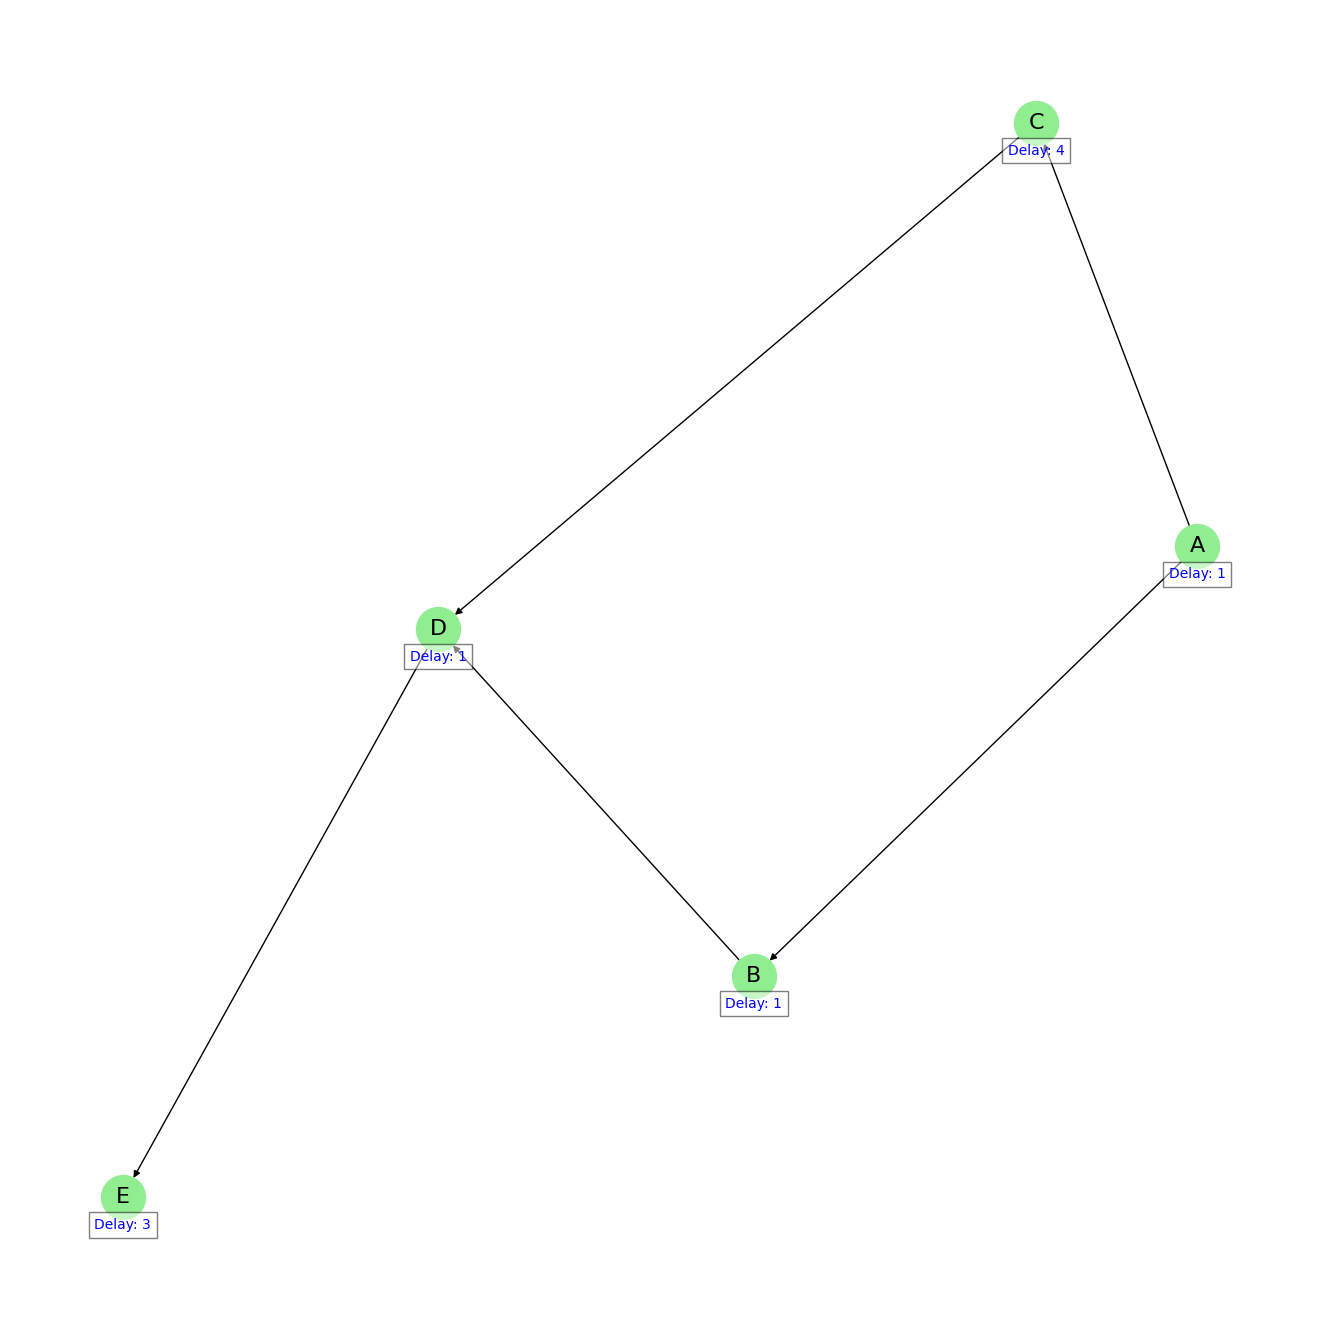

In [99]:
draw_graph(tasks, edges, delays, "inicijalni_primer", order)

In [100]:
def save_results(file, data):
    with open(file, 'w') as file:
        json.dump(data, file, indent=4)
    print(f"Data saved to {file}")

In [101]:
def load_test_data(path_to_test):
    files = os.listdir(path_to_test)
    data_files = [f for f in files if f.startswith('test_file_') and f.endswith('.json')]
    data = []
    
    for file_name in data_files:
        file_path = os.path.join(path_to_test, file_name)
        with open(file_path, 'r') as f:
            loaded_data = json.load(f)
            tasks = loaded_data.get('tasks')
            edges = loaded_data.get('edges')
            delays = loaded_data.get('delays')
            data.append([tasks, edges, delays, file_name])

    return data

In [102]:
def grid_search(data, mutation_funcs, crossover_funcs, param_grid, file_name):
    results = []

    best_result = None
    
    for mutation_func, crossover_func, params in product(mutation_funcs, crossover_funcs, param_grid):
        population_size = params['population_size']
        num_generations = params['num_generations']
        tournament_size = params['tournament_size']
        elitism_size = params['elitism_size']
        mutation_prob = params['mutation_prob']

        tasks, edges, delays, file_name = data[0], data[1], data[2], data[3]
        solution, cost, time_taken = genetic_algorithm(mutation_func, 
                                                          crossover_func, 
                                                          population_size, 
                                                          num_generations, 
                                                          tournament_size, 
                                                          elitism_size, 
                                                          mutation_prob,
                                                          tasks, edges, delays)
        
        result = {
            'mutation_func': mutation_func.__name__,
            'crossover_func': crossover_func.__name__,
            'population_size': population_size,
            'num_generations': num_generations,
            'tournament_size': tournament_size,
            'elitism_size': elitism_size,
            'mutation_prob': mutation_prob,
            'solution': solution,
            'cost': cost,
            'time_taken': time_taken
        }

        if best_result is None or (result.get('cost'),result.get('time_taken')) < (best_result.get('cost'), best_result.get('time_taken')):
            best_result = result
        
        results.append(result)

    print(f"Best Result: {best_result}")

    sorted_data = sorted(results, key=lambda x: (x.get('cost'), x.get('time_taken')))
    save_results(f'results/big_data/GA_fine_tuning/ga_results_{file_name}', sorted_data)

    return sorted_data

### Performing GridSearch to find best combinations of params and functions

In [103]:
# population_size_range = [15, 20, 25, 30] 
# num_generations_range = [15, 20, 25, 30]
# tournament_size_range = [7, 8, 9]
# elitism_size_range = [9, 11, 13]
# mutation_prob_range = [0.3, 0.4, 0.5]

# param_grid = [
#     {
#         'population_size': population_size,
#         'num_generations': num_generations,
#         'tournament_size': tournament_size,
#         'elitism_size': elitism_size,
#         'mutation_prob': mutation_prob
#     }
#     for population_size in population_size_range
#     for num_generations in num_generations_range
#     for tournament_size in tournament_size_range
#     for elitism_size in elitism_size_range
#     for mutation_prob in mutation_prob_range
# ]

# print(f"Total combinations: {len(param_grid)}")
# print(param_grid[:5])

# crossover_funcs = [crossover, partially_mapped_crossover, cycle_crossover]
# mutation_funcs = [mutate, inversion_mutation, scramble_mutation, mutate_number_of_times, swap_and_invert_mutation]  

# datas = load_test_data('test_files/big_data/')

# all_results = []
# for data in datas:
#     print("--------------------------")
#     print("file: ", data[3])
#     results = grid_search(data, mutation_funcs, crossover_funcs, param_grid, data[3])
#     all_results.append(results)

In [104]:
def test_alg(path_to_test, path_to_results, big_data=False): 
    files = os.listdir(path_to_test)
    data_files = [f for f in files if f.startswith('test_file_') and f.endswith('.json')]
    data_to_write = []

    for file_name in data_files:
        file_path = os.path.join(path_to_test, file_name)
        with open(file_path, 'r') as f:
            loaded_data = json.load(f)
            tasks = loaded_data.get('tasks')
            edges = loaded_data.get('edges')
            delays = loaded_data.get('delays')

            # rough idea of best parameters after performing grid search
            order, cost, time_taken = genetic_algorithm(    
                                                        mutate,
                                                        crossover,
                                                        population_size=40, 
                                                        num_generations=40, 
                                                        tournament_size=9,
                                                        elitism_size=7,
                                                        mutation_prob=0.5,
                                                        tasks=tasks,
                                                        edges=edges,
                                                        delays=delays
                                                        )
        
            draw_graph(tasks, edges, delays, file_name[:-5] + "_graph", big_data, order)
            print("----------------------------------------------")
            data = {
            'test_name' : file_name,
            'order_of_tasks': order,
            'finish_time': cost,
            'time_taken': time_taken
            }
            data_to_write.append(data)
    
    save_results(path_to_results, data_to_write)

### Test on small data

solution: ['B', 'A', 'E', 'C', 'D'], cost: 10, time taken: 0.06432294845581055


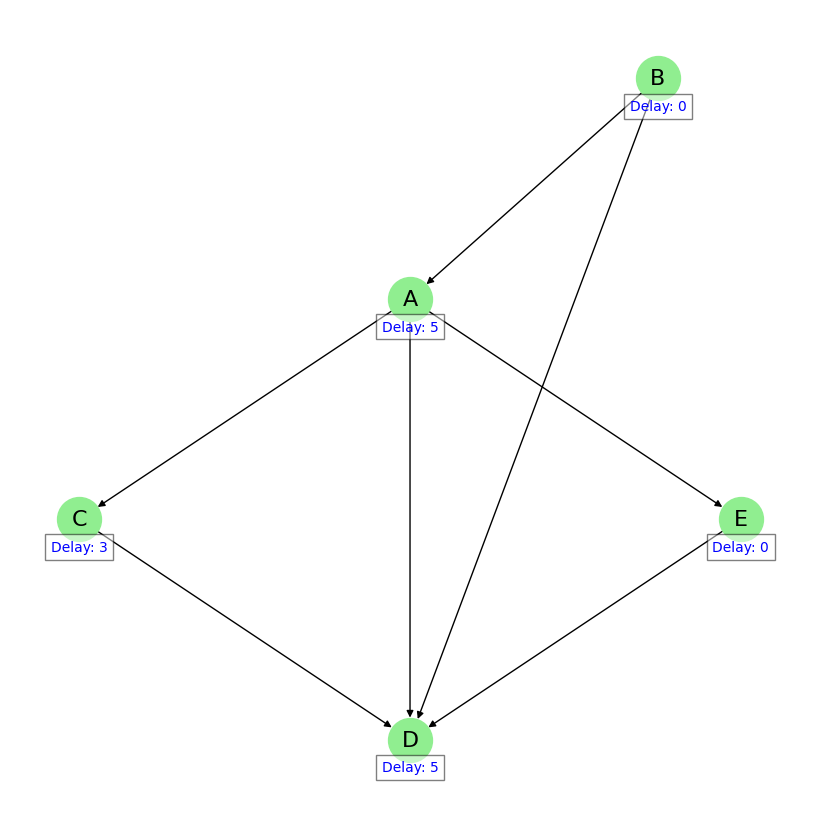

----------------------------------------------
solution: ['D', 'G', 'B', 'A', 'H', 'C', 'E', 'F'], cost: 14, time taken: 0.06480979919433594


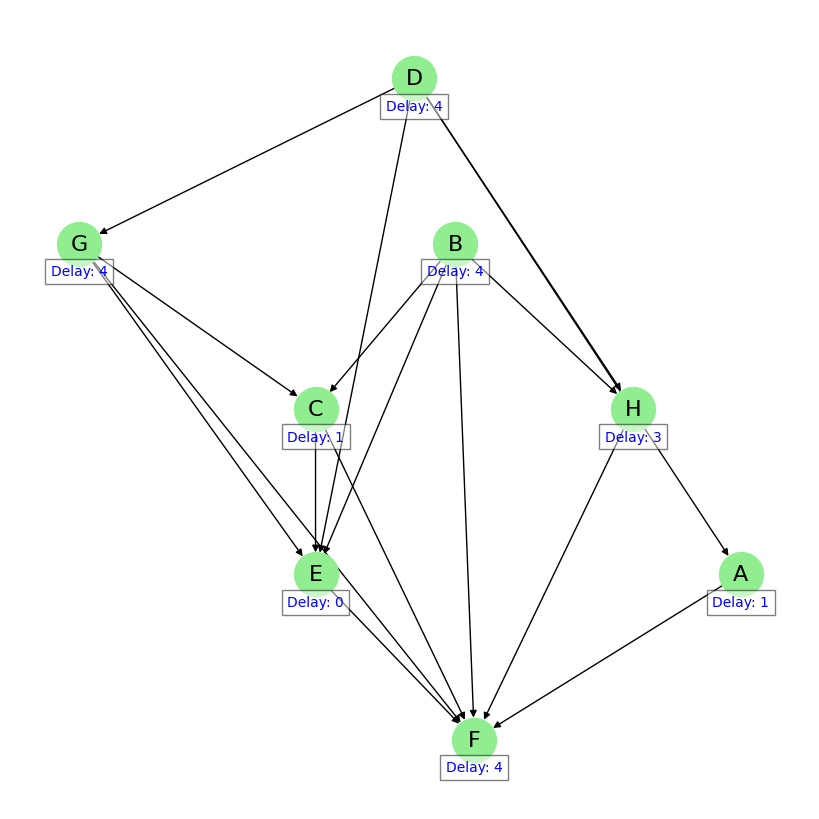

----------------------------------------------
solution: ['B', 'E', 'A', 'D', 'F', 'C', 'G'], cost: 16, time taken: 0.0611577033996582


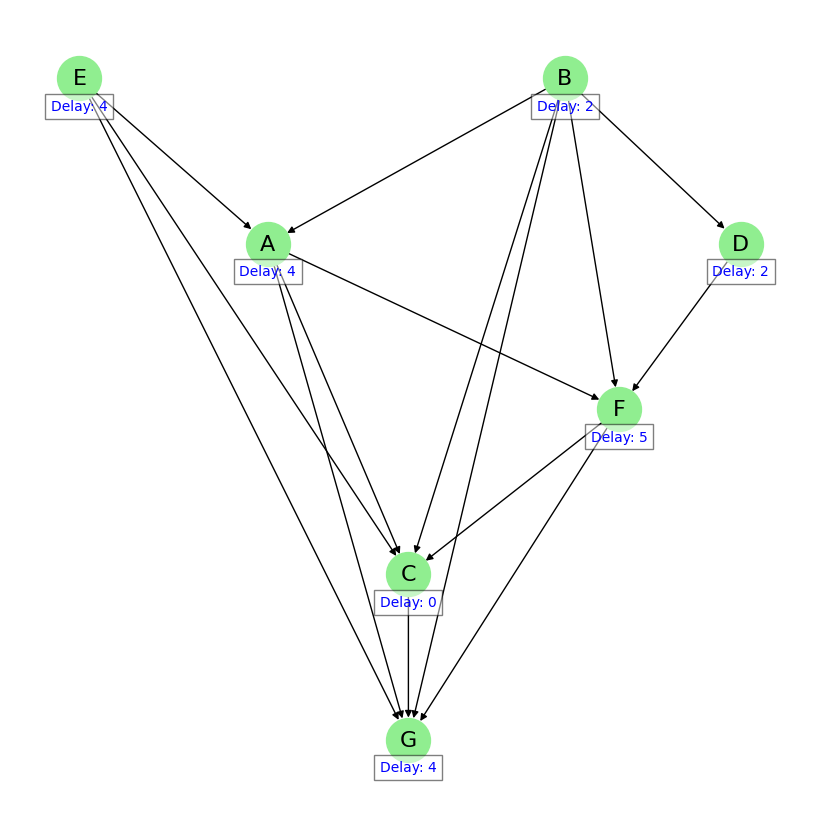

----------------------------------------------
solution: ['B', 'F', 'E', 'A', 'C', 'D'], cost: 13, time taken: 0.05668759346008301


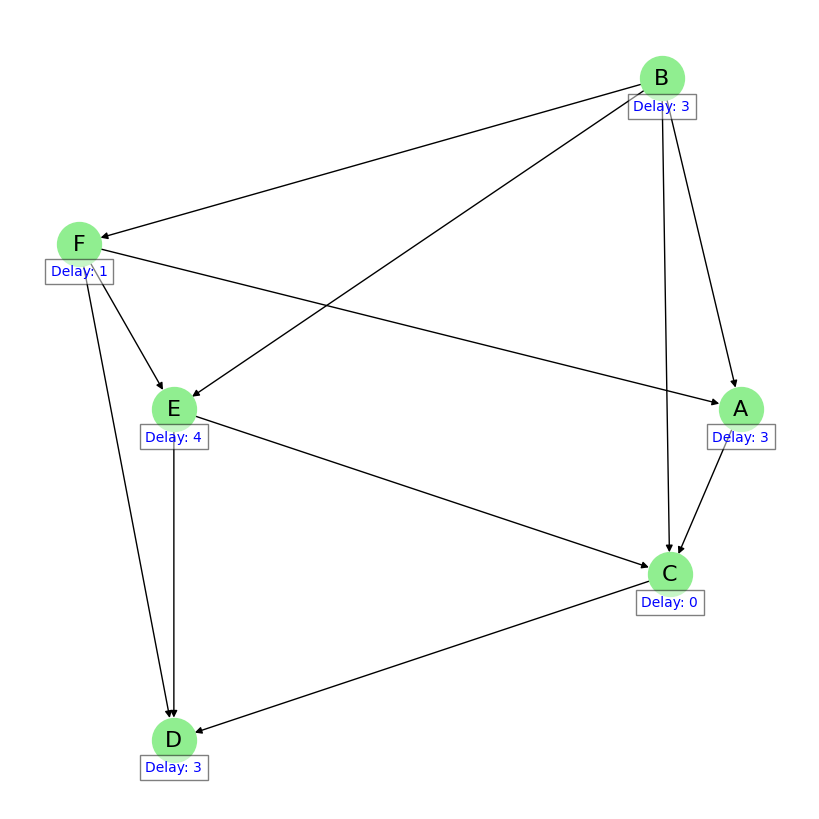

----------------------------------------------
solution: ['C', 'H', 'A', 'E', 'G', 'D', 'B', 'I', 'F'], cost: 11, time taken: 0.06184220314025879


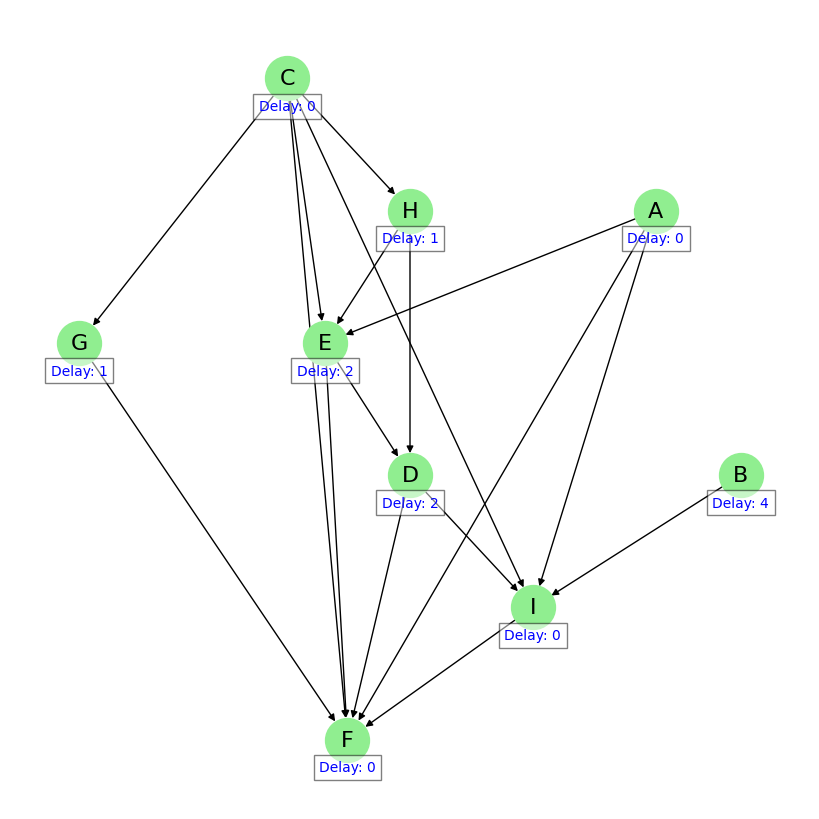

----------------------------------------------
Data saved to <_io.TextIOWrapper name='results/small_data/GA.json' mode='w' encoding='UTF-8'>


In [105]:
test_file = 'test_files/small_data/'
result_file = 'results/small_data/GA.json'
test_alg(test_file, result_file, False)

### Test on big data

solution: ['J', 'H', 'A', 'I', 'Q', 'N', 'C', 'K', 'U', 'S', 'E', 'V', 'P', 'L', 'F', 'G', 'M', 'D', 'R', 'B', 'O', 'T'], cost: 42, time taken: 0.1510021686553955


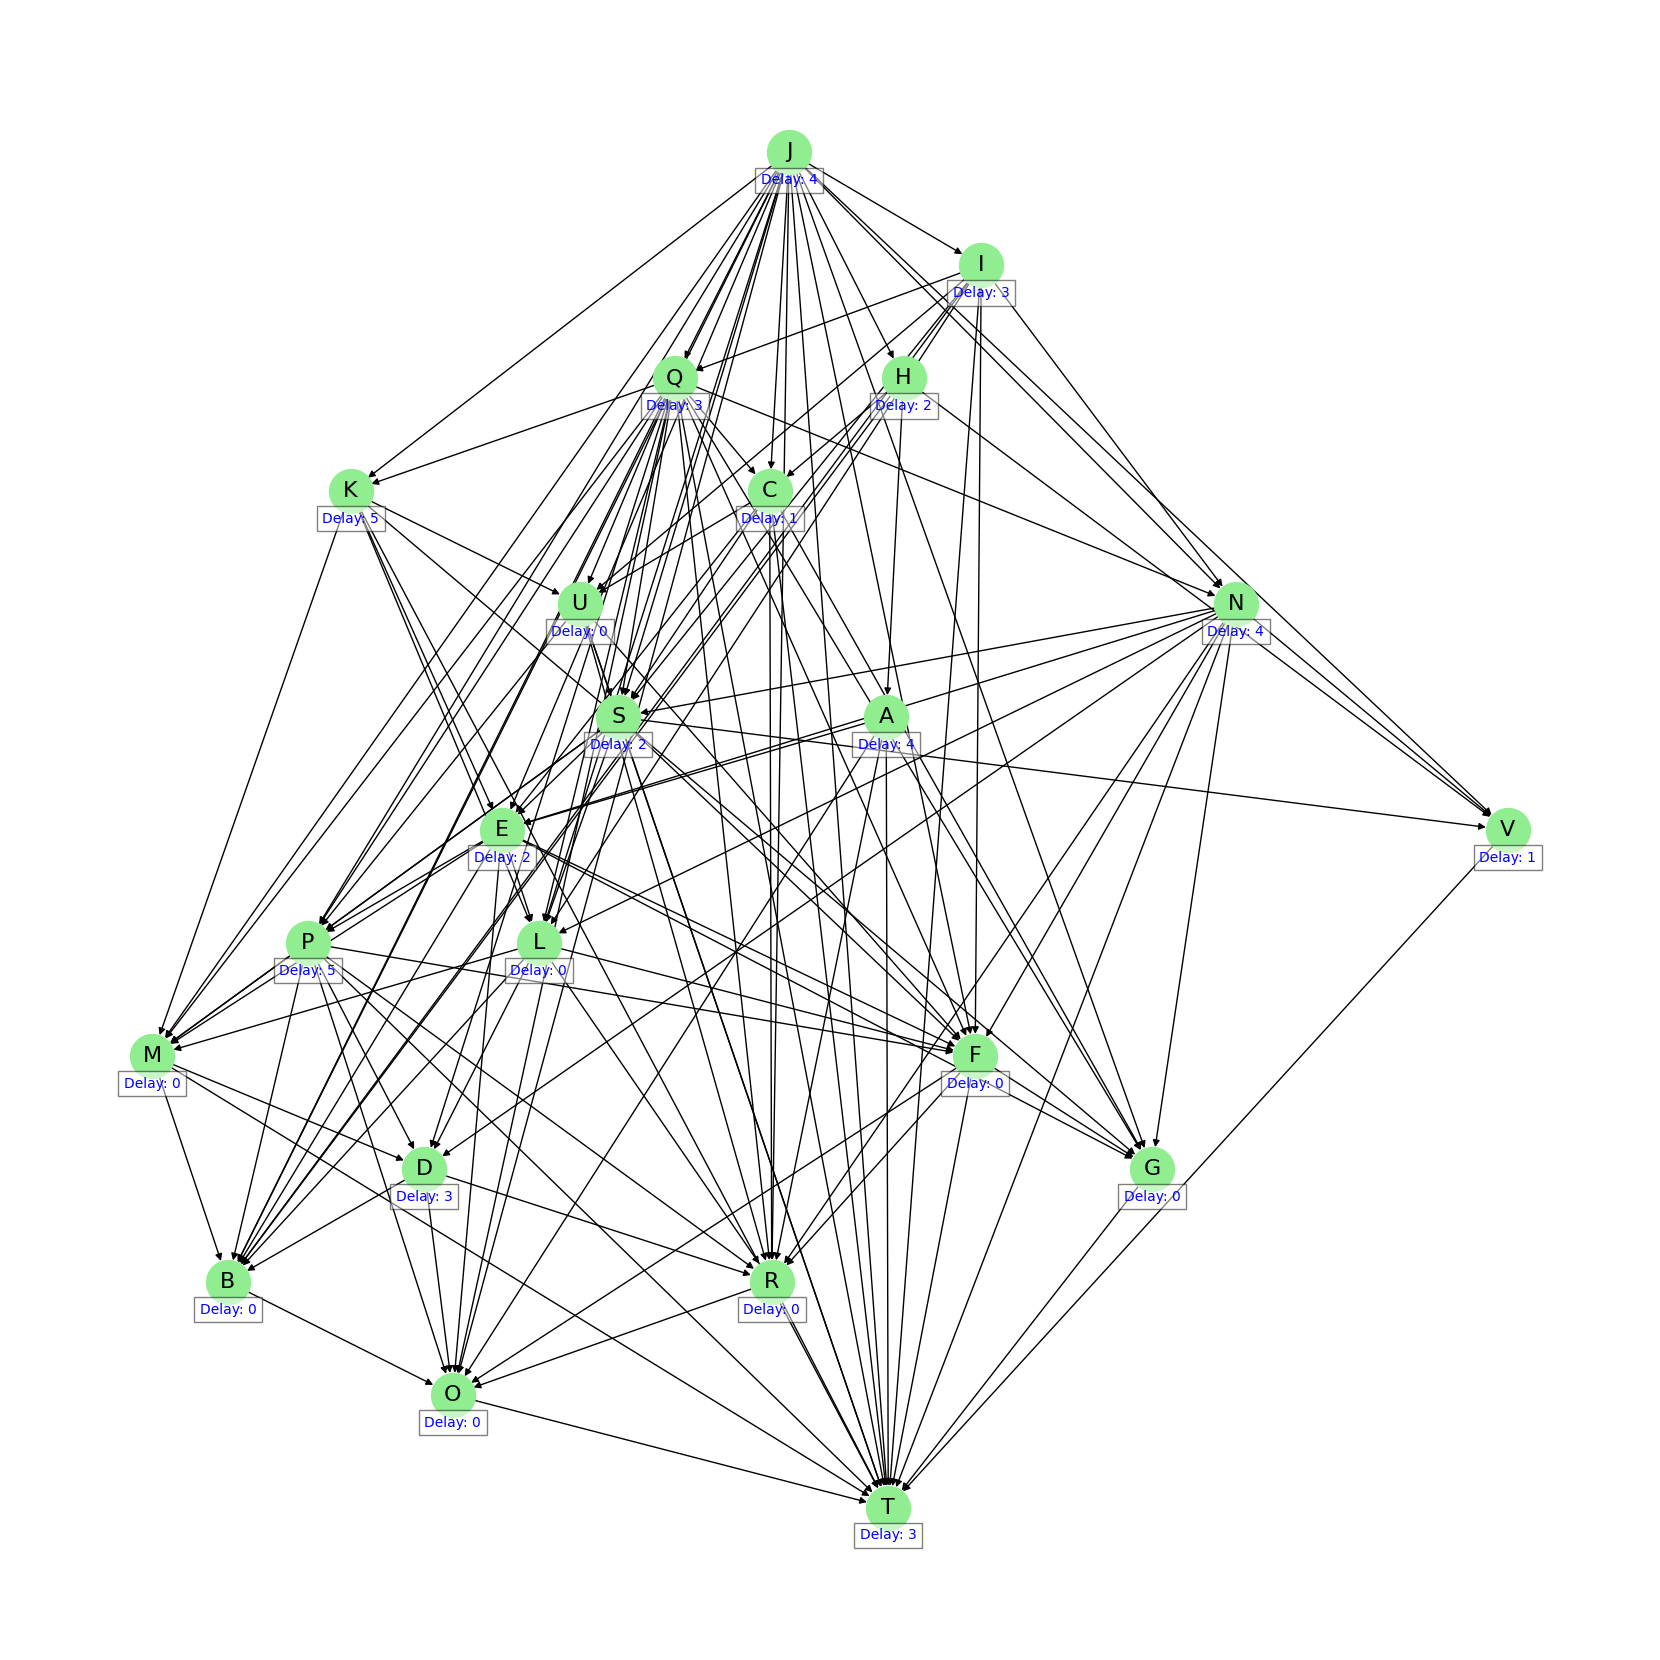

----------------------------------------------
solution: ['H', 'I', 'F', 'W', 'R', 'D', 'Q', 'G', 'U', 'O', 'C', 'P', 'E', 'V', 'X', 'B', 'K', 'S', 'M', 'T', 'J', 'A', 'N', 'L'], cost: 58, time taken: 0.14609432220458984


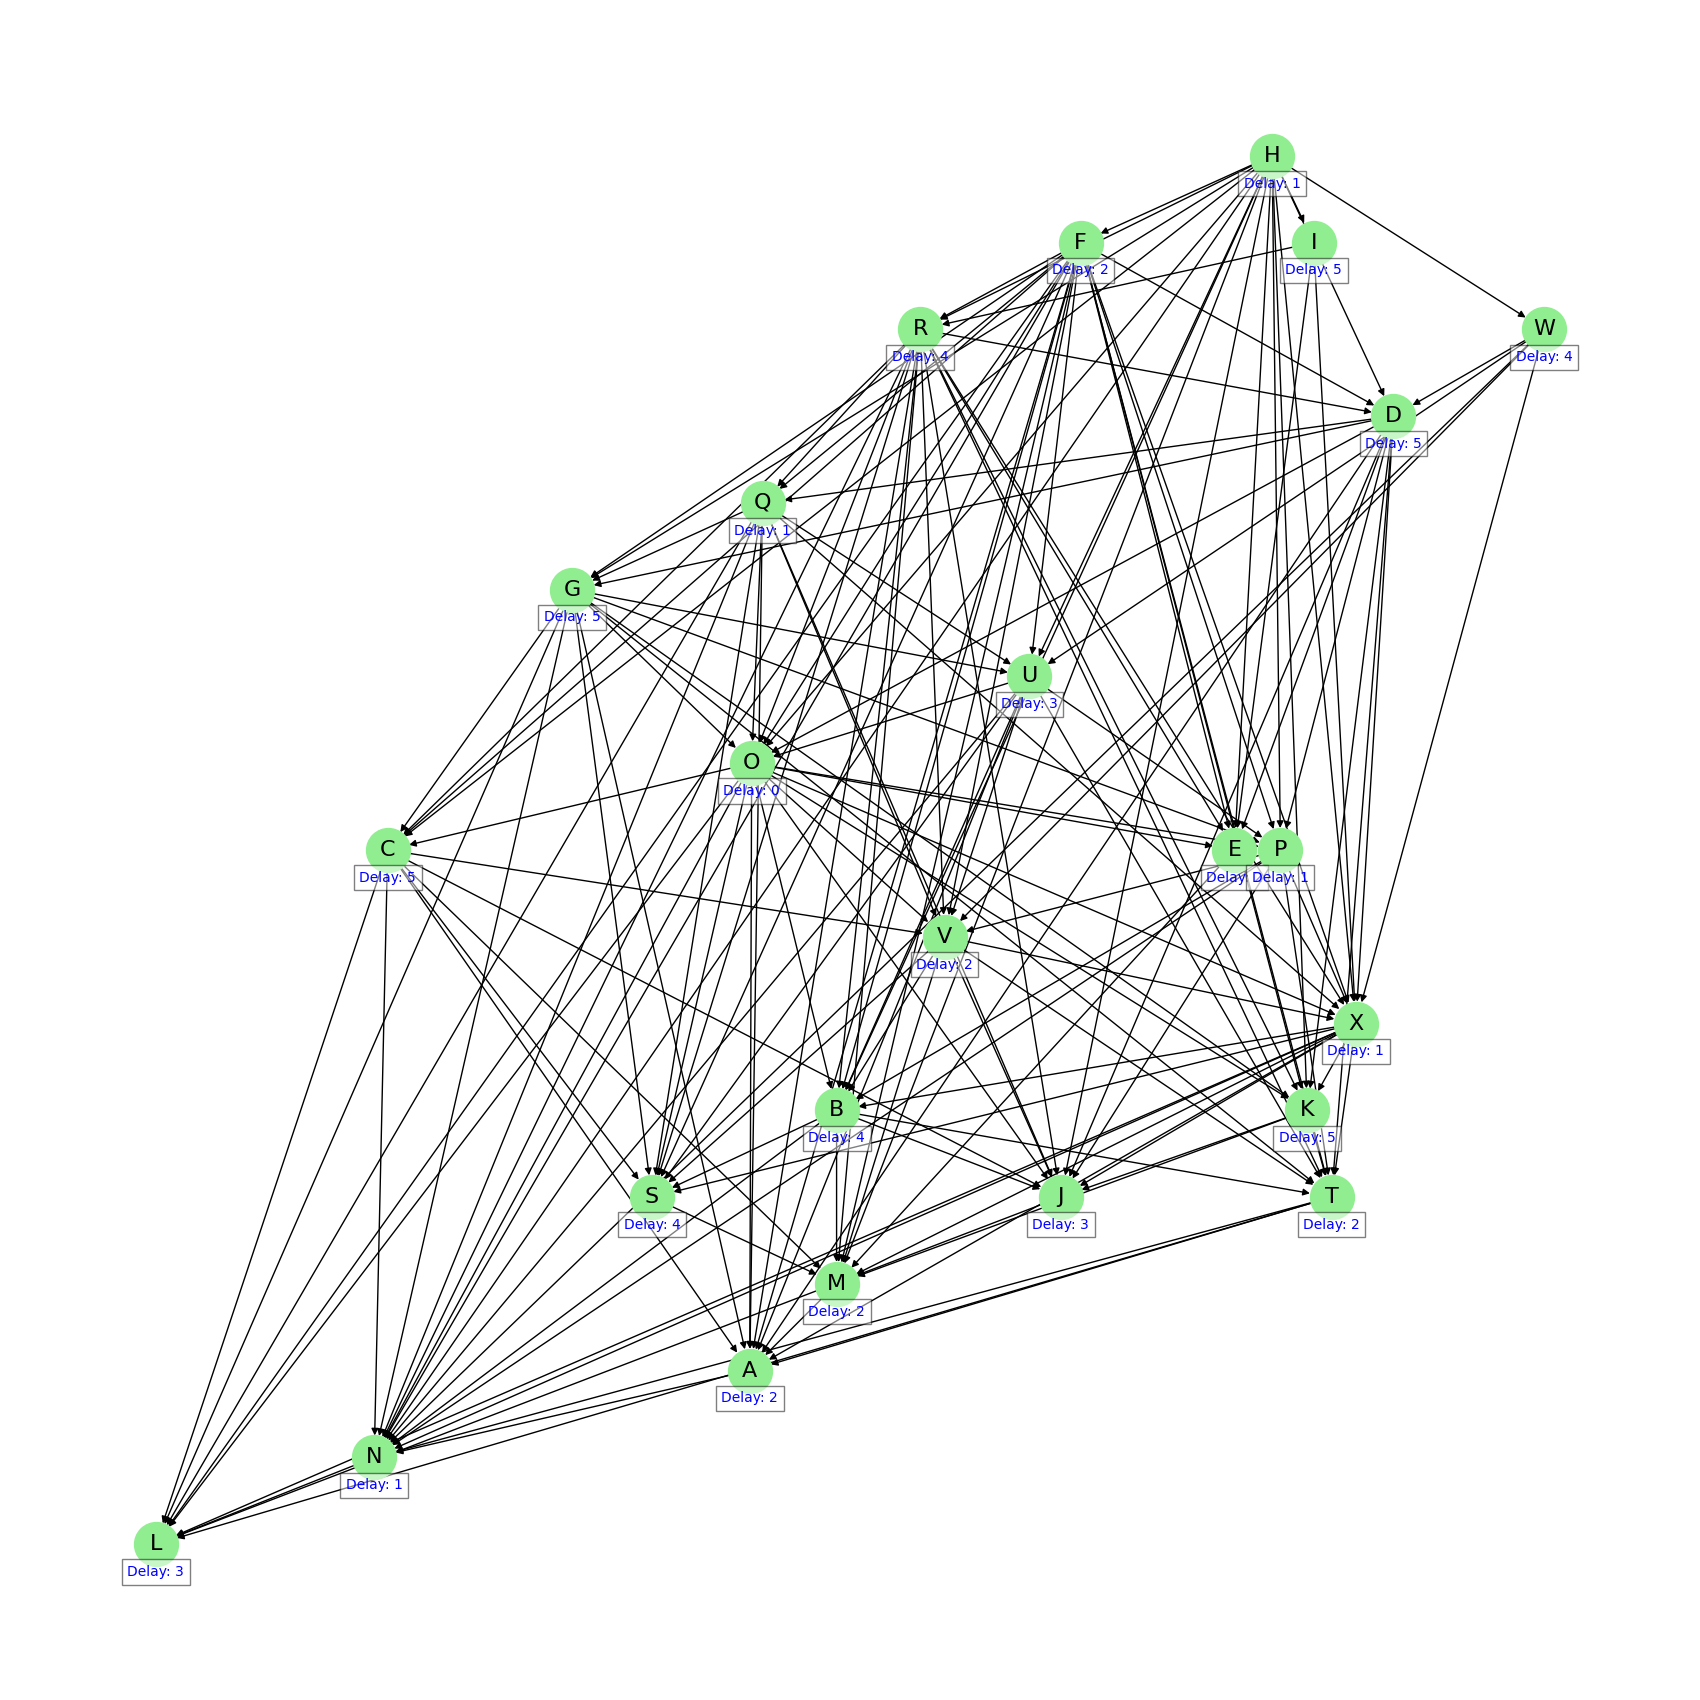

----------------------------------------------
solution: ['E', 'G', 'Q', 'N', 'F', 'M', 'K', 'I', 'H', 'O', 'L', 'S', 'B', 'C', 'P', 'D', 'J', 'R', 'A', 'T'], cost: 49, time taken: 0.12964749336242676


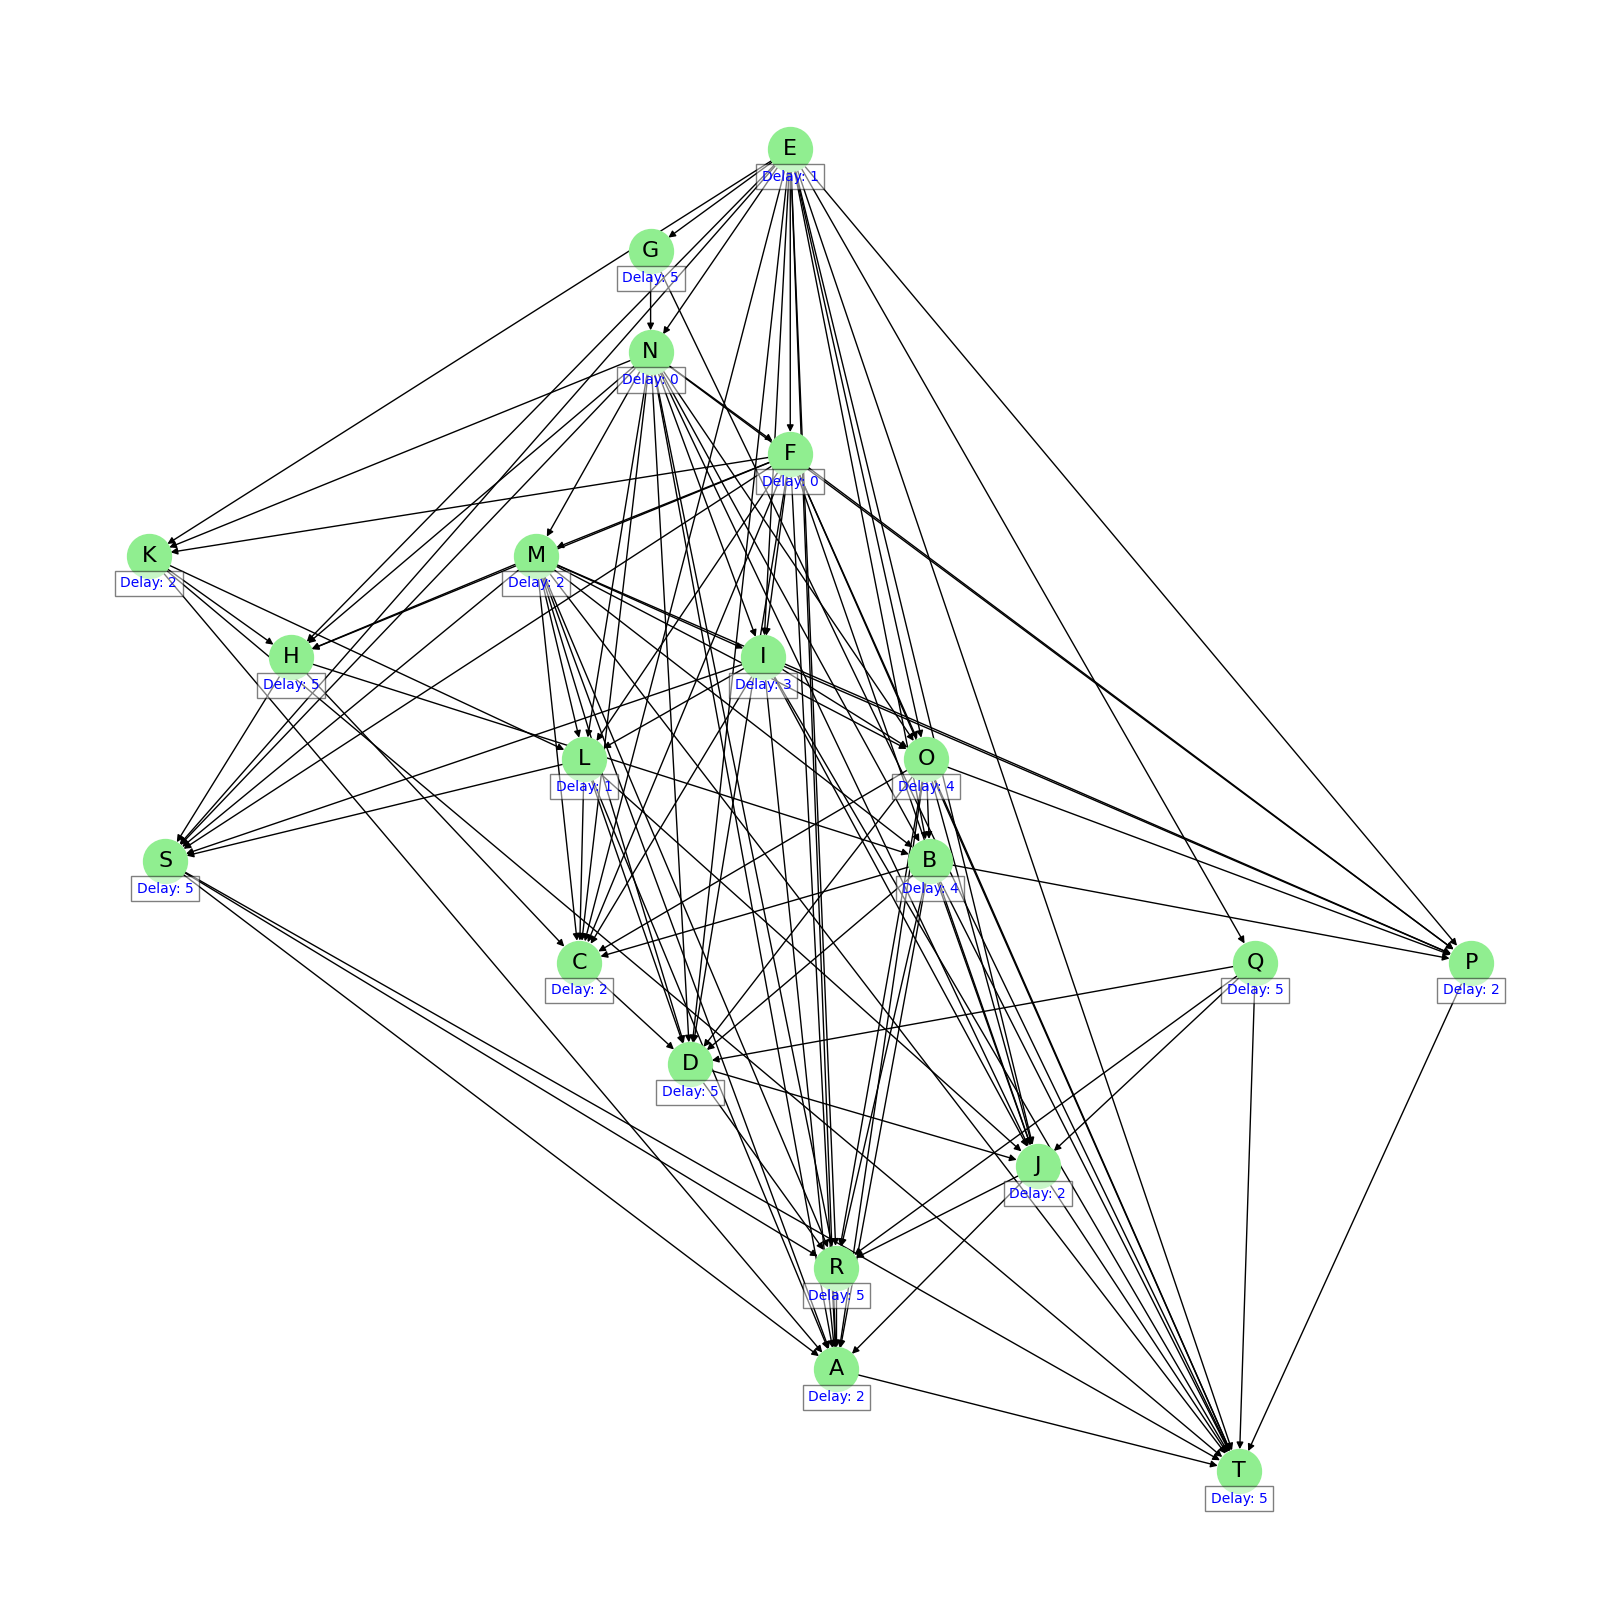

----------------------------------------------
solution: ['B', 'P', 'G', 'K', 'T', 'Q', 'M', 'I', 'A', 'H', 'C', 'S', 'D', 'R', 'J', 'F', 'O', 'L', 'N', 'U', 'E'], cost: 41, time taken: 0.1335141658782959


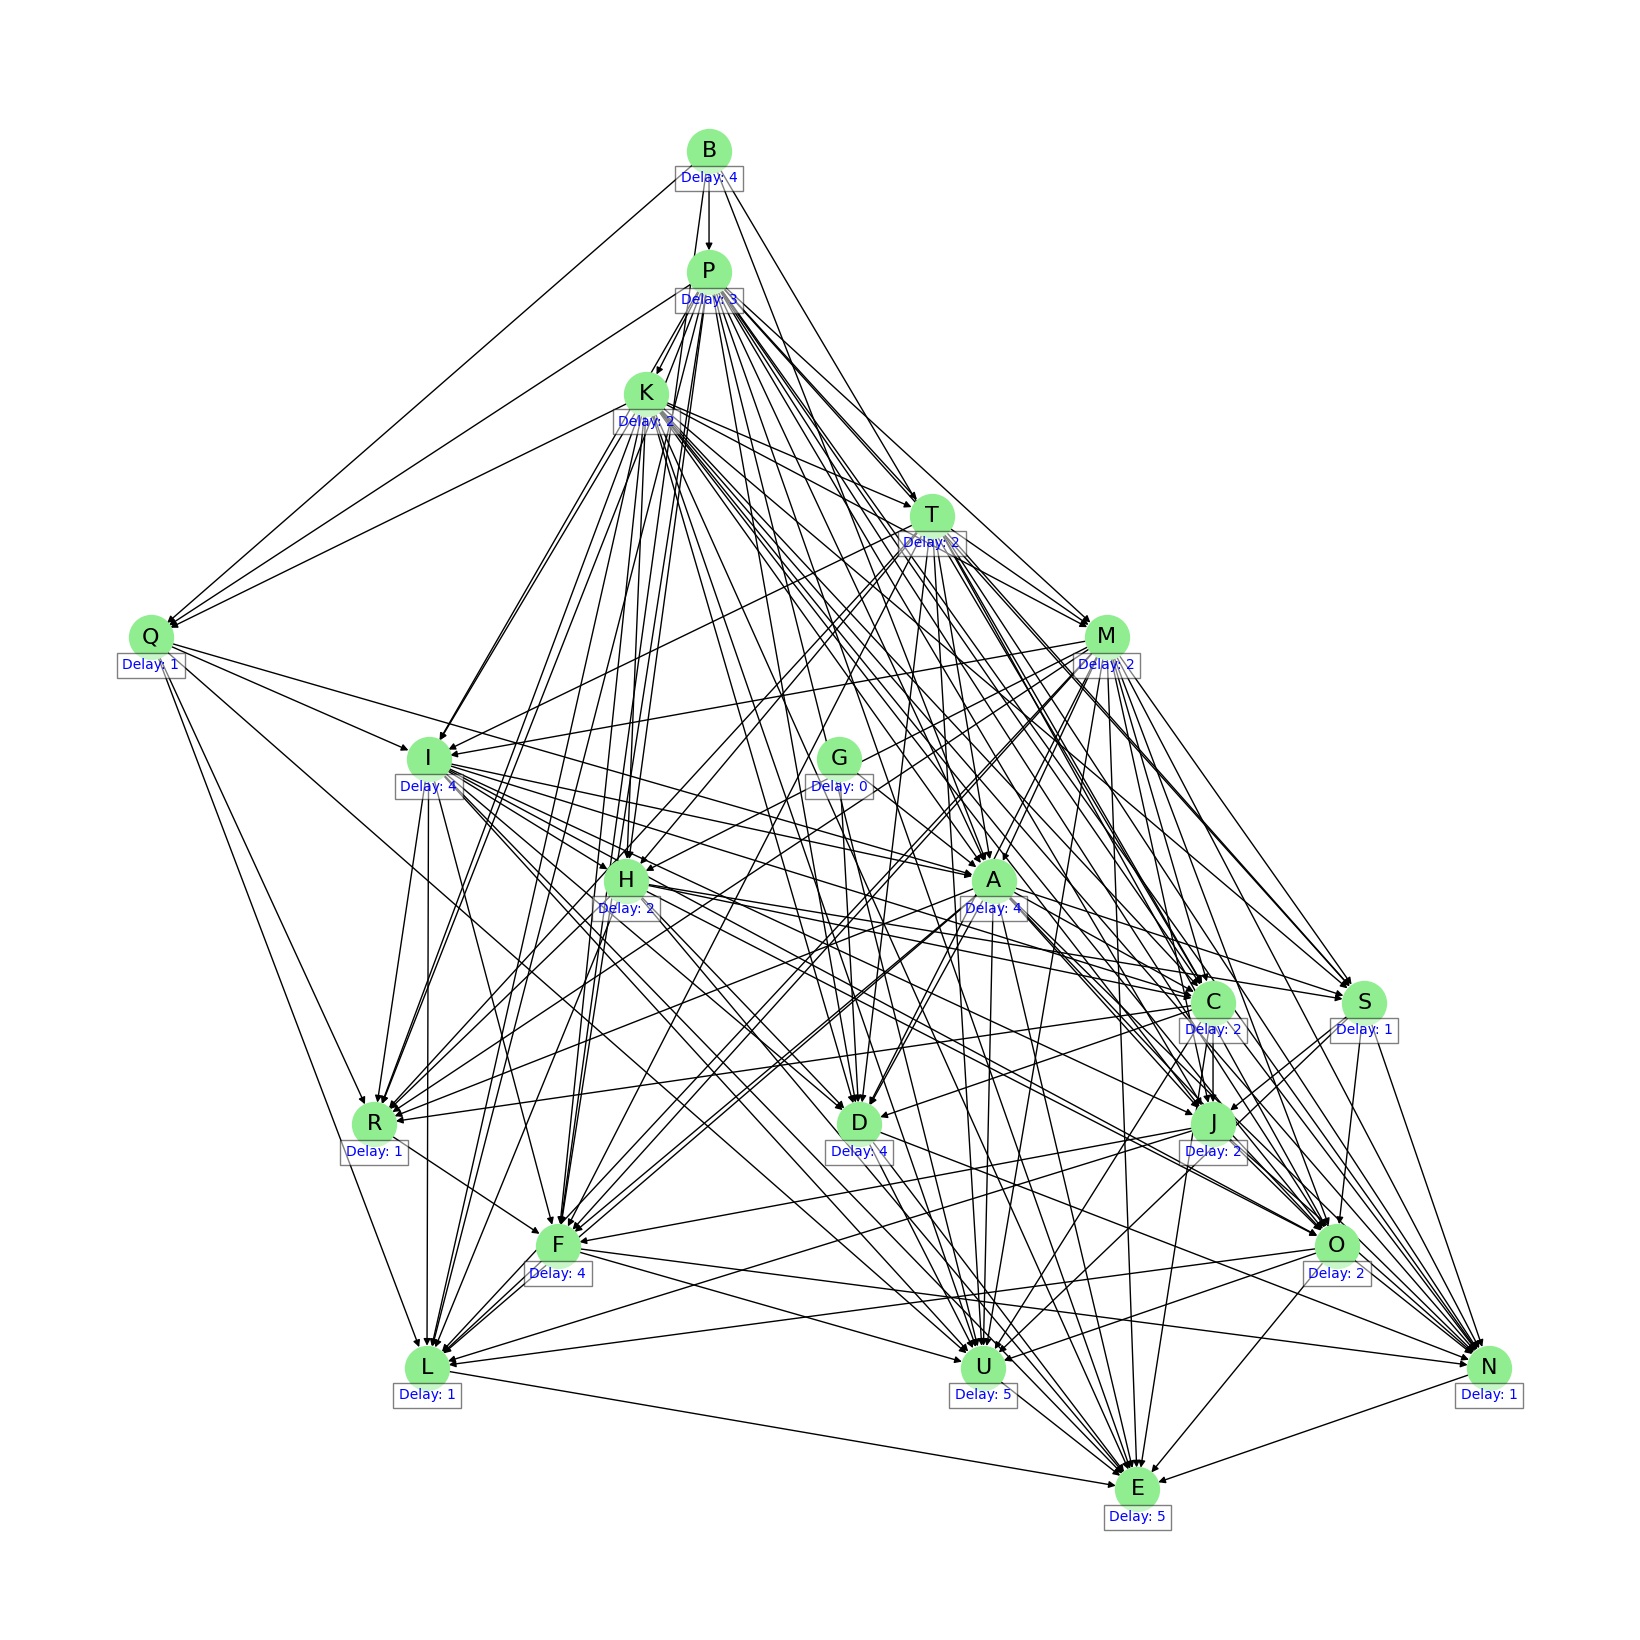

----------------------------------------------
solution: ['N', 'W', 'J', 'S', 'K', 'B', 'C', 'H', 'A', 'G', 'L', 'D', 'Q', 'V', 'P', 'I', 'O', 'E', 'U', 'T', 'M', 'F', 'R'], cost: 45, time taken: 0.14180207252502441


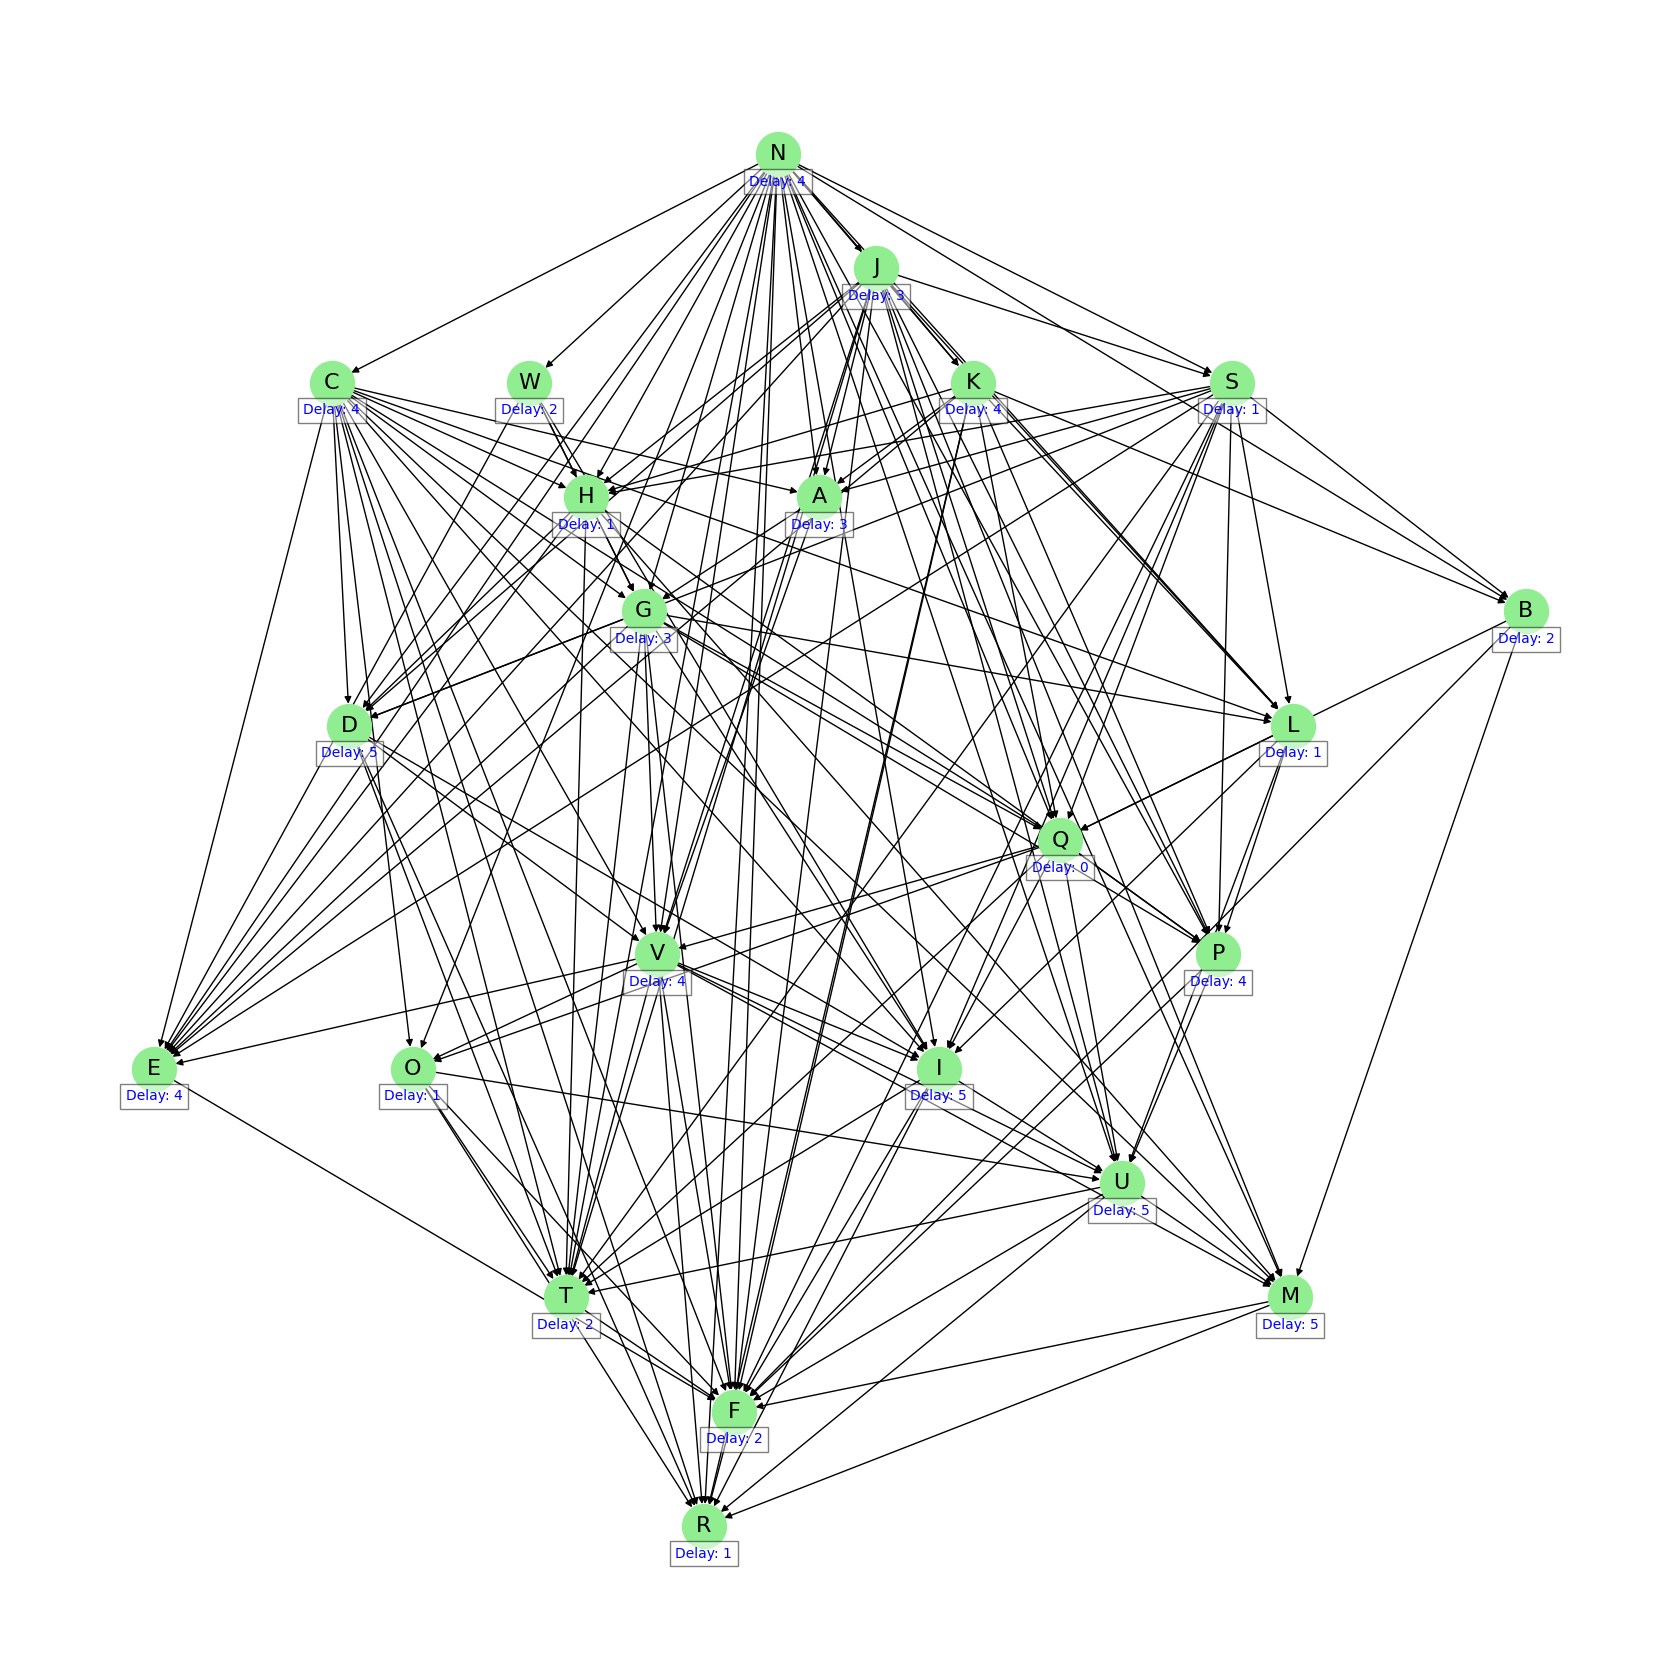

----------------------------------------------
Data saved to <_io.TextIOWrapper name='results/big_data/GA.json' mode='w' encoding='UTF-8'>


In [96]:
test_file = 'test_files/big_data/'
result_file = 'results/big_data/GA.json'
test_alg(test_file, result_file, True)